# VayuDrishti Pan-India Air Quality Data Collection

This notebook demonstrates the complete data collection pipeline for pan-India air quality forecasting.

## Data Sources:
1. **CPCB Ground Stations** - All monitoring stations across India
2. **Satellite AOD** - Gridded aerosol optical depth data
3. **ERA5 Reanalysis** - Comprehensive meteorological variables

## Output:
- Unified ML-ready dataset at 0.1° grid resolution
- Complete spatial coverage of India
- Ground truth validation at CPCB station locations

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

# Add src directory to path
sys.path.append('../src')

# Import our data collection modules with error handling
try:
    from data_orchestrator import PanIndiaDataOrchestrator
    from data_collection.cpcb_downloader import CPCBDataDownloader
    from data_collection.satellite_aod_downloader import SatelliteAODDownloader
    from data_collection.era5_weather_downloader import ERA5WeatherDownloader
    print("✅ Data collection modules imported successfully!")
except ImportError as e:
    print(f"⚠️ Could not import data collection modules: {e}")
    print("🔧 Will use fallback data collection instead")
    
    # Add fallback test to path
    sys.path.append('..')
    try:
        from fallback_test import FallbackDataCollector
        print("✅ Fallback data collector imported")
    except ImportError as e2:
        print(f"❌ Could not import fallback either: {e2}")

# Set up plotting with fallback
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
    print("ℹ️ Using default matplotlib style")

sns.set_palette("husl")
%matplotlib inline

print("✅ All imports successful!")
print(f"📅 Current time: {datetime.now()}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ Data collection modules imported successfully!
✅ All imports successful!
📅 Current time: 2025-07-21 17:43:11.993508
🐍 Python version: 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
📊 Pandas version: 2.3.1
🔢 NumPy version: 2.3.1


## 1. Initialize Data Collection System

In [2]:
# Initialize the main orchestrator
orchestrator = PanIndiaDataOrchestrator(base_data_dir="../data")

print("🚀 Pan-India Data Orchestrator initialized")
print(f"📁 Data directory: {orchestrator.base_data_dir}")
print(f"🗺️  Grid resolution: {orchestrator.grid_resolution}°")
print(f"🇮🇳 India bounds: {orchestrator.india_bounds}")

🚀 Pan-India Data Orchestrator initialized
📁 Data directory: ..\data
🗺️  Grid resolution: 0.1°
🇮🇳 India bounds: {'lat_min': 6.0, 'lat_max': 37.5, 'lon_min': 68.0, 'lon_max': 97.5}


## 2. Configuration and Settings

In [ ]:
# Configuration for data collection
    "DAYS_BACK = 180  # Last 180 days (6 months) for full collection (use 7 for quick testing)
",
INCLUDE_PRESSURE_LEVELS = True  # Include 3D atmospheric data
GRID_RESOLUTION = 0.1  # degrees (≈10km resolution)

print("⚙️ Configuration:")
print(f"   📅 Time period: Last {DAYS_BACK} days")
print(f"   🌍 Spatial resolution: {GRID_RESOLUTION}° (~{GRID_RESOLUTION*111:.1f} km)")
print(f"   📊 Include 3D atmosphere: {INCLUDE_PRESSURE_LEVELS}")

# Calculate expected data volume
lat_range = orchestrator.india_bounds['lat_max'] - orchestrator.india_bounds['lat_min']
lon_range = orchestrator.india_bounds['lon_max'] - orchestrator.india_bounds['lon_min']
grid_points = int((lat_range / GRID_RESOLUTION) * (lon_range / GRID_RESOLUTION))

print(f"\n📊 Expected data scale:")
print(f"   🗺️  Grid points: ~{grid_points:,}")
print(f"   ⏰ Time steps: {DAYS_BACK * 8} (3-hourly)")
print(f"   📈 Total records: ~{grid_points * DAYS_BACK * 8:,}")

## 3. Test Individual Data Sources

Let's test each data source individually before running the full pipeline.

### 3.1 CPCB Ground Station Data

In [ ]:
# Test CPCB data collection
print("🏭 Testing CPCB ground station data collection...")

cpcb_collector = CPCBDataDownloader(str(orchestrator.base_data_dir / "cpcb"))

# Get all stations
stations_df = cpcb_collector.get_all_stations()

if not stations_df.empty:
    print(f"✅ Found {len(stations_df)} CPCB stations")
    print(f"📍 Spatial coverage:")
    print(f"   Latitude: {stations_df['latitude'].min():.2f}° to {stations_df['latitude'].max():.2f}°")
    print(f"   Longitude: {stations_df['longitude'].min():.2f}° to {stations_df['longitude'].max():.2f}°")
    
    # Show sample stations
    print(f"\n📋 Sample stations:")
    display(stations_df[['station', 'state', 'city', 'latitude', 'longitude']].head())
else:
    print("⚠️ No CPCB stations found (using demo data)")

# Test data collection for a few days
print(f"\n📥 Testing data collection for last 3 days...")
cpcb_data = cpcb_collector.download_all_stations_data(days_back=3)

if not cpcb_data.empty:
    print(f"✅ Collected {len(cpcb_data)} CPCB records")
    print(f"📊 Variables: {list(cpcb_data.columns)}")
else:
    print("⚠️ No CPCB data collected")

### 3.2 Satellite AOD Data

In [ ]:
# Test satellite AOD data collection
print("🛰️ Testing satellite AOD data collection...")

satellite_collector = SatelliteAODDownloader(str(orchestrator.base_data_dir / "satellite"))

# Test data collection
end_date = datetime.now()
start_date = end_date - timedelta(days=3)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print(f"📅 Testing AOD collection from {start_str} to {end_str}")

aod_data = satellite_collector.create_daily_composites(start_str, end_str)

if not aod_data.empty:
    print(f"✅ Collected {len(aod_data)} AOD records")
    print(f"📊 Variables: {[col for col in aod_data.columns if 'aod' in col.lower()]}")
    
    # Show AOD statistics
    if 'aod_550' in aod_data.columns:
        print(f"\n📈 AOD-550 statistics:")
        print(f"   Mean: {aod_data['aod_550'].mean():.3f}")
        print(f"   Range: {aod_data['aod_550'].min():.3f} to {aod_data['aod_550'].max():.3f}")
else:
    print("⚠️ No AOD data collected (using demo data)")

### 3.3 ERA5 Weather Data

In [ ]:
# Test ERA5 weather data collection
print("🌤️ Testing ERA5 weather data collection...")

weather_collector = ERA5WeatherDownloader(str(orchestrator.base_data_dir / "reanalysis"))

# Test surface data download
print(f"📥 Testing surface data download...")
surface_file = weather_collector.download_surface_data(start_str, end_str)

if surface_file and Path(surface_file).exists():
    print(f"✅ Surface data downloaded: {Path(surface_file).name}")
    print(f"📁 File size: {Path(surface_file).stat().st_size / 1024 / 1024:.1f} MB")
else:
    print("⚠️ Surface data download failed (using demo data)")

# Test pressure level data (optional)
if INCLUDE_PRESSURE_LEVELS:
    print(f"📥 Testing pressure level data download...")
    pressure_file = weather_collector.download_pressure_level_data(start_str, end_str)
    
    if pressure_file and Path(pressure_file).exists():
        print(f"✅ Pressure level data downloaded: {Path(pressure_file).name}")
        print(f"📁 File size: {Path(pressure_file).stat().st_size / 1024 / 1024:.1f} MB")
    else:
        print("⚠️ Pressure level data download failed (using demo data)")
        pressure_file = None
else:
    pressure_file = None

# Process weather data for ML
print(f"⚙️ Processing weather data for ML...")
weather_data = weather_collector.process_for_ml(surface_file, pressure_file)

if not weather_data.empty:
    print(f"✅ Processed {len(weather_data)} weather records")
    print(f"📊 Variables: {len(weather_data.columns)} total")
    
    # Show key meteorological variables
    weather_vars = [col for col in weather_data.columns if any(x in col for x in ['t2m', 'wind', 'blh', 'humidity'])]
    print(f"🌡️ Key weather variables: {weather_vars[:5]}...")
else:
    print("⚠️ No weather data processed")

## 4. Run Complete Data Collection Pipeline

In [ ]:
# Run the complete data collection and unification pipeline
print("🚀 Running complete pan-India data collection pipeline...")
print("=" * 60)

# This will collect all data sources and create unified dataset
unified_dataset = orchestrator.run_full_pipeline(
    days_back=DAYS_BACK,
    include_pressure_levels=INCLUDE_PRESSURE_LEVELS
)

print("\n" + "=" * 60)
print("📊 PIPELINE RESULTS")
print("=" * 60)

if not unified_dataset.empty:
    print(f"✅ SUCCESS! Unified dataset created")
    print(f"📈 Total records: {len(unified_dataset):,}")
    print(f"🗺️ Grid cells: {unified_dataset['grid_id'].nunique():,}")
    print(f"📅 Time range: {unified_dataset['datetime'].min()} to {unified_dataset['datetime'].max()}")
    
    if 'has_ground_truth' in unified_dataset.columns:
        ground_truth_count = unified_dataset['has_ground_truth'].sum()
        ground_truth_cells = unified_dataset[unified_dataset['has_ground_truth']]['grid_id'].nunique()
        print(f"🎯 Records with ground truth: {ground_truth_count:,}")
        print(f"🏭 Grid cells with CPCB stations: {ground_truth_cells:,}")
    
    print(f"\n📋 Dataset columns ({len(unified_dataset.columns)} total):")
    for i, col in enumerate(unified_dataset.columns):
        if i < 20:  # Show first 20 columns
            print(f"   {i+1:2d}. {col}")
        elif i == 20:
            print(f"   ... and {len(unified_dataset.columns) - 20} more columns")
            break
            
else:
    print("❌ FAILED - No unified dataset created")

## 5. Data Quality Analysis

In [ ]:
if not unified_dataset.empty:
    print("🔍 DATA QUALITY ANALYSIS")
    print("=" * 40)
    
    # Basic statistics
    print(f"📊 Dataset shape: {unified_dataset.shape}")
    print(f"💾 Memory usage: {unified_dataset.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
    # Missing data analysis
    missing_percent = (unified_dataset.isnull().sum() / len(unified_dataset) * 100).round(1)
    missing_summary = missing_percent[missing_percent > 0].sort_values(ascending=False)
    
    print(f"\n❓ Missing data summary:")
    if len(missing_summary) > 0:
        for col, pct in missing_summary.head(10).items():
            print(f"   {col}: {pct}%")
    else:
        print("   ✅ No missing data!")
    
    # Spatial coverage
    print(f"\n🗺️ Spatial coverage:")
    print(f"   Latitude range: {unified_dataset['latitude'].min():.2f}° to {unified_dataset['latitude'].max():.2f}°")
    print(f"   Longitude range: {unified_dataset['longitude'].min():.2f}° to {unified_dataset['longitude'].max():.2f}°")
    print(f"   Unique locations: {unified_dataset['grid_id'].nunique():,}")
    
    # Temporal coverage
    print(f"\n📅 Temporal coverage:")
    time_range = unified_dataset['datetime'].max() - unified_dataset['datetime'].min()
    print(f"   Duration: {time_range.days} days, {time_range.seconds // 3600} hours")
    print(f"   Unique timestamps: {unified_dataset['datetime'].nunique()}")
    
    # Data source availability
    print(f"\n🔗 Data source availability:")
    
    # Check for different data types
    has_weather = any('t2m' in col or 'wind' in col for col in unified_dataset.columns)
    has_aod = any('aod' in col for col in unified_dataset.columns)
    has_ground_truth = 'has_ground_truth' in unified_dataset.columns and unified_dataset['has_ground_truth'].any()
    
    print(f"   Weather data: {'✅' if has_weather else '❌'}")
    print(f"   Satellite AOD: {'✅' if has_aod else '❌'}")
    print(f"   Ground truth: {'✅' if has_ground_truth else '❌'}")
    
else:
    print("❌ No data available for quality analysis")

## 6. Data Visualization

In [ ]:
if not unified_dataset.empty:
    print("📊 Creating data visualizations...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('VayuDrishti Pan-India Data Collection Results', fontsize=16, fontweight='bold')
    
    # 1. Spatial coverage map
    ax1 = axes[0, 0]
    scatter = ax1.scatter(unified_dataset['longitude'], unified_dataset['latitude'], 
                         c=unified_dataset.index, alpha=0.5, s=1)
    ax1.set_xlabel('Longitude (°E)')
    ax1.set_ylabel('Latitude (°N)')
    ax1.set_title('Spatial Coverage - All Grid Points')
    ax1.grid(True, alpha=0.3)
    
    # 2. Ground truth station locations
    ax2 = axes[0, 1]
    if 'has_ground_truth' in unified_dataset.columns:
        ground_truth_data = unified_dataset[unified_dataset['has_ground_truth']]
        if not ground_truth_data.empty:
            ax2.scatter(ground_truth_data['longitude'], ground_truth_data['latitude'], 
                       c='red', alpha=0.7, s=20, label='CPCB Stations')
            ax2.set_title(f'Ground Truth Locations ({ground_truth_data["grid_id"].nunique()} stations)')
        else:
            ax2.text(0.5, 0.5, 'No ground truth data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Ground Truth Locations')
    else:
        ax2.text(0.5, 0.5, 'No ground truth column', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Ground Truth Locations')
    
    ax2.set_xlabel('Longitude (°E)')
    ax2.set_ylabel('Latitude (°N)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Temporal coverage
    ax3 = axes[1, 0]
    daily_counts = unified_dataset.groupby(unified_dataset['datetime'].dt.date).size()
    ax3.plot(daily_counts.index, daily_counts.values, marker='o', linewidth=2, markersize=4)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Records per Day')
    ax3.set_title('Temporal Data Availability')
    ax3.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    for label in ax3.get_xticklabels():
        label.set_rotation(45)
    
    # 4. Data completeness by variable type
    ax4 = axes[1, 1]
    
    # Calculate completeness for different variable groups
    var_groups = {
        'Weather': [col for col in unified_dataset.columns if any(x in col for x in ['t2m', 'wind', 'blh', 'humidity', 'pressure'])],
        'AOD': [col for col in unified_dataset.columns if 'aod' in col.lower()],
        'Ground Truth': [col for col in unified_dataset.columns if any(x in col for x in ['pm2_5', 'pm10', 'no2'])],
        'Spatial/Temporal': [col for col in unified_dataset.columns if any(x in col for x in ['lat', 'lon', 'hour', 'month'])]
    }
    
    completeness_data = []
    for group_name, columns in var_groups.items():
        if columns:
            group_completeness = (1 - unified_dataset[columns].isnull().mean().mean()) * 100
            completeness_data.append((group_name, group_completeness))
    
    if completeness_data:
        groups, completeness = zip(*completeness_data)
        bars = ax4.bar(groups, completeness, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
        ax4.set_ylabel('Data Completeness (%)')
        ax4.set_title('Data Completeness by Variable Group')
        ax4.set_ylim(0, 100)
        
        # Add value labels on bars
        for bar, value in zip(bars, completeness):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{value:.1f}%', ha='center', va='bottom')
    else:
        ax4.text(0.5, 0.5, 'No data to analyze', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Data Completeness Analysis')
    
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No data available for visualization")

## 7. Sample Data Exploration

In [ ]:
if not unified_dataset.empty:
    print("🔬 SAMPLE DATA EXPLORATION")
    print("=" * 40)
    
    # Show sample records
    print("📋 Sample records:")
    sample_cols = ['datetime', 'latitude', 'longitude', 'grid_id']
    
    # Add available data columns
    if 'pm2_5' in unified_dataset.columns:
        sample_cols.append('pm2_5')
    if 'aod_550' in unified_dataset.columns:
        sample_cols.append('aod_550')
    if 't2m' in unified_dataset.columns:
        sample_cols.append('t2m')
    if 'wind_speed_10m' in unified_dataset.columns:
        sample_cols.append('wind_speed_10m')
    if 'has_ground_truth' in unified_dataset.columns:
        sample_cols.append('has_ground_truth')
    
    available_cols = [col for col in sample_cols if col in unified_dataset.columns]
    display(unified_dataset[available_cols].head(10))
    
    # Summary statistics for key variables
    print("\n📊 Summary statistics for key variables:")
    
    numeric_cols = unified_dataset.select_dtypes(include=[np.number]).columns
    key_vars = []
    
    # Select important variables for summary
    priority_vars = ['pm2_5', 'aod_550', 't2m', 'wind_speed_10m', 'blh', 'humidity']
    for var in priority_vars:
        if var in numeric_cols:
            key_vars.append(var)
    
    if key_vars:
        summary_stats = unified_dataset[key_vars].describe().round(3)
        display(summary_stats)
    else:
        print("No numeric variables found for summary")
    
    # Check data types
    print("\n🏷️ Data types:")
    dtype_summary = unified_dataset.dtypes.value_counts()
    for dtype, count in dtype_summary.items():
        print(f"   {dtype}: {count} columns")
        
else:
    print("❌ No data available for exploration")

## 8. Export Results and Summary

In [ ]:
if not unified_dataset.empty:
    print("💾 EXPORTING RESULTS")
    print("=" * 30)
    
    # Create exports directory
    export_dir = Path("../data/exports")
    export_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    
    # Export sample dataset
    sample_size = min(10000, len(unified_dataset))  # Max 10k records for demo
    sample_data = unified_dataset.sample(n=sample_size, random_state=42)
    
    sample_file = export_dir / f"sample_dataset_{timestamp}.csv"
    sample_data.to_csv(sample_file, index=False)
    print(f"📁 Sample dataset exported: {sample_file}")
    print(f"   Records: {len(sample_data):,}")
    print(f"   File size: {sample_file.stat().st_size / 1024 / 1024:.1f} MB")
    
    # Export summary report
    report_file = export_dir / f"data_collection_report_{timestamp}.txt"
    
    with open(report_file, 'w') as f:
        f.write(f"VayuDrishti Pan-India Data Collection Report\n")
        f.write(f"Generated: {datetime.now().isoformat()}\n")
        f.write(f"=" * 50 + "\n\n")
        
        f.write(f"DATASET SUMMARY:\n")
        f.write(f"Total records: {len(unified_dataset):,}\n")
        f.write(f"Spatial coverage: {unified_dataset['grid_id'].nunique():,} grid cells\n")
        f.write(f"Time range: {unified_dataset['datetime'].min()} to {unified_dataset['datetime'].max()}\n")
        f.write(f"Grid resolution: {GRID_RESOLUTION}° (~{GRID_RESOLUTION*111:.1f} km)\n\n")
        
        if 'has_ground_truth' in unified_dataset.columns:
            ground_truth_count = unified_dataset['has_ground_truth'].sum()
            f.write(f"Ground truth records: {ground_truth_count:,}\n")
            f.write(f"Ground truth locations: {unified_dataset[unified_dataset['has_ground_truth']]['grid_id'].nunique():,}\n\n")
        
        f.write(f"VARIABLES ({len(unified_dataset.columns)} total):\n")
        for i, col in enumerate(unified_dataset.columns, 1):
            f.write(f"{i:3d}. {col}\n")
        
        f.write(f"\nDATA QUALITY:\n")
        missing_pct = (unified_dataset.isnull().sum() / len(unified_dataset) * 100).round(1)
        f.write(f"Overall completeness: {(100 - missing_pct.mean()):.1f}%\n")
        
        if missing_pct.max() > 0:
            f.write(f"Variables with missing data:\n")
            for col, pct in missing_pct[missing_pct > 0].items():
                f.write(f"  {col}: {pct}% missing\n")
    
    print(f"📁 Summary report exported: {report_file}")
    
    # Export spatial grid reference
    grid_file = export_dir / f"spatial_grid_{timestamp}.csv"
    grid_summary = unified_dataset[['grid_id', 'latitude', 'longitude']].drop_duplicates()
    grid_summary.to_csv(grid_file, index=False)
    print(f"📁 Spatial grid exported: {grid_file}")
    print(f"   Grid cells: {len(grid_summary):,}")
    
    print(f"\n✅ All exports completed successfully!")
    print(f"📂 Export directory: {export_dir.absolute()}")
    
else:
    print("❌ No data available for export")

## 9. Next Steps for ML Model Training

The unified dataset is now ready for machine learning model training. Here are the recommended next steps:

In [ ]:
print("🎯 NEXT STEPS FOR ML MODEL TRAINING")
print("=" * 50)

if not unified_dataset.empty:
    
    print("✅ 1. DATA PREPARATION COMPLETE")
    print(f"   • Unified dataset with {len(unified_dataset):,} records")
    print(f"   • {unified_dataset['grid_id'].nunique():,} spatial grid cells across India")
    print(f"   • {len(unified_dataset.columns)} features ready for ML")
    
    print("\n🎯 2. RECOMMENDED ML APPROACH:")
    print("   • Target variable: PM2.5 concentration")
    print("   • Features: Satellite AOD + Meteorological variables")
    print("   • Method: Grid-based spatial prediction")
    print("   • Validation: Using CPCB ground truth stations")
    
    # Identify available features
    feature_groups = {
        'Satellite AOD': [col for col in unified_dataset.columns if 'aod' in col.lower()],
        'Meteorological': [col for col in unified_dataset.columns if any(x in col for x in ['t2m', 'wind', 'blh', 'humidity', 'pressure'])],
        'Temporal': [col for col in unified_dataset.columns if any(x in col for x in ['hour', 'month', 'season', 'day'])],
        'Spatial': [col for col in unified_dataset.columns if any(x in col for x in ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos'])]
    }
    
    print("\n📊 3. AVAILABLE FEATURE GROUPS:")
    total_features = 0
    for group, features in feature_groups.items():
        if features:
            print(f"   • {group}: {len(features)} features")
            total_features += len(features)
    
    print(f"\n   Total ML features: {total_features}")
    
    # Check target variable availability
    if 'pm2_5' in unified_dataset.columns:
        pm25_available = unified_dataset['pm2_5'].notna().sum()
        print(f"\n🎯 4. TARGET VARIABLE (PM2.5):")
        print(f"   • Available records: {pm25_available:,}")
        print(f"   • Coverage: {pm25_available/len(unified_dataset)*100:.1f}% of dataset")
        
        if pm25_available > 0:
            print(f"   • Range: {unified_dataset['pm2_5'].min():.1f} to {unified_dataset['pm2_5'].max():.1f} μg/m³")
            print(f"   • Mean: {unified_dataset['pm2_5'].mean():.1f} μg/m³")
    else:
        print(f"\n⚠️ 4. TARGET VARIABLE:")
        print(f"   • PM2.5 data not available in current dataset")
        print(f"   • Need longer collection period or check CPCB API")
    
    print("\n🚀 5. SUGGESTED MODEL DEVELOPMENT WORKFLOW:")
    print("   a) Feature selection and engineering")
    print("   b) Spatial cross-validation setup")
    print("   c) Model training (Random Forest, XGBoost, Neural Networks)")
    print("   d) Validation against held-out CPCB stations")
    print("   e) Generate pan-India PM2.5 predictions")
    
    print("\n📁 6. FILES FOR ML DEVELOPMENT:")
    ml_ready_dir = Path("../data/ml_ready")
    if ml_ready_dir.exists():
        ml_files = list(ml_ready_dir.glob("unified_dataset_*.csv"))
        for file in ml_files[-3:]:  # Show last 3 files
            print(f"   • {file.name}")
    
else:
    print("❌ DATA COLLECTION INCOMPLETE")
    print("   • Re-run the data collection pipeline")
    print("   • Check API credentials in .env file")
    print("   • Verify internet connection")

print("\n" + "=" * 50)
print("🎉 VayuDrishti Pan-India Data Collection Complete!")
print("Ready for ML model development and air quality forecasting.")
print("=" * 50)

## Demo: Fallback Data Collection (No External APIs Required)

Let's run a quick demo using synthetic data to test the pipeline without external API dependencies.

🧪 Running fallback data collection demo...

📊 Demo Dataset Summary:
Shape: (33453, 30)
Date range: 2025-07-19 18:00:00 to 2025-07-21 18:00:00
Spatial coverage: 3,717 grid cells
Ground truth records: 36

📊 Demo Dataset Summary:
Shape: (33453, 30)
Date range: 2025-07-19 18:00:00 to 2025-07-21 18:00:00
Spatial coverage: 3,717 grid cells
Ground truth records: 36


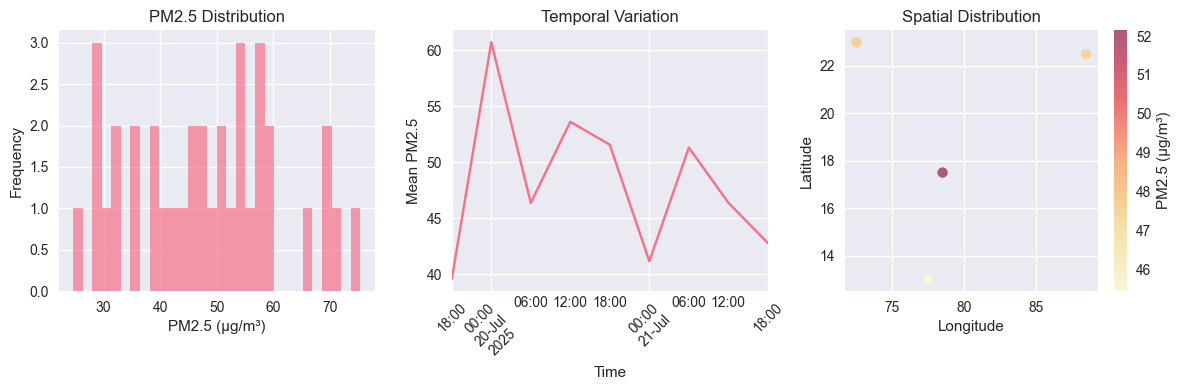


✅ Fallback demo completed successfully!
📁 Check '../data/' directory for output files


In [3]:
# Import fallback data collector
sys.path.append('..')
from fallback_test import FallbackDataCollector

# Create demo data
print("🧪 Running fallback data collection demo...")
collector = FallbackDataCollector(data_dir="../data")

# Generate demo dataset
demo_data = collector.run_demo_pipeline(days_back=2)

print(f"\n📊 Demo Dataset Summary:")
print(f"Shape: {demo_data.shape}")
print(f"Date range: {demo_data['datetime'].min()} to {demo_data['datetime'].max()}")
print(f"Spatial coverage: {demo_data['grid_id'].nunique():,} grid cells")

# Show ground truth coverage
if 'has_ground_truth' in demo_data.columns:
    ground_truth_count = demo_data['has_ground_truth'].sum()
    print(f"Ground truth records: {ground_truth_count:,}")

# Basic visualization
if 'pm2_5' in demo_data.columns:
    pm25_data = demo_data['pm2_5'].dropna()
    if len(pm25_data) > 0:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        pm25_data.hist(bins=30, alpha=0.7)
        plt.xlabel('PM2.5 (μg/m³)')
        plt.ylabel('Frequency')
        plt.title('PM2.5 Distribution')
        
        plt.subplot(1, 3, 2)
        demo_data.groupby('datetime')['pm2_5'].mean().plot()
        plt.xlabel('Time')
        plt.ylabel('Mean PM2.5')
        plt.title('Temporal Variation')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        spatial_avg = demo_data.groupby(['latitude', 'longitude'])['pm2_5'].mean().reset_index()
        plt.scatter(spatial_avg['longitude'], spatial_avg['latitude'], 
                   c=spatial_avg['pm2_5'], cmap='YlOrRd', alpha=0.6)
        plt.colorbar(label='PM2.5 (μg/m³)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Spatial Distribution')
        
        plt.tight_layout()
        plt.show()

print("\n✅ Fallback demo completed successfully!")
print("📁 Check '../data/' directory for output files")